Episode: 0, duration: 19
Episode: 1, duration: 14


C:\Users\rdesa\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Episode: 2, duration: 29
Episode: 3, duration: 36
Episode: 4, duration: 14
Episode: 5, duration: 36
Episode: 6, duration: 19
Episode: 7, duration: 53
Episode: 8, duration: 16
Episode: 9, duration: 12
Episode: 10, duration: 21
Episode: 11, duration: 28
Episode: 12, duration: 11
Episode: 13, duration: 11
Episode: 14, duration: 10
Episode: 15, duration: 20
Episode: 16, duration: 11
Episode: 17, duration: 20
Episode: 18, duration: 17
Episode: 19, duration: 19
Episode: 20, duration: 20
Episode: 21, duration: 11
Episode: 22, duration: 23
Episode: 23, duration: 13
Episode: 24, duration: 18
Episode: 25, duration: 16
Episode: 26, duration: 17
Episode: 27, duration: 17
Episode: 28, duration: 19
Episode: 29, duration: 10
Episode: 30, duration: 17
Episode: 31, duration: 13
Episode: 32, duration: 46
Episode: 33, duration: 19
Episode: 34, duration: 18
Episode: 35, duration: 17
Episode: 36, duration: 11
Episode: 37, duration: 21
Episode: 38, duration: 16
Episode: 39, duration: 12
Episode: 40, duratio

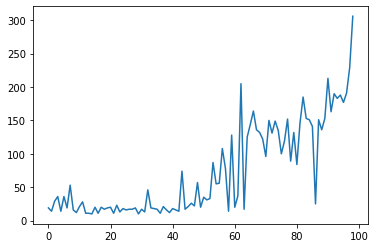

Duration: 767
Duration: 1242
Duration: 1361
Duration: 1182
Duration: 280
Duration: 1678
Duration: 4513
Duration: 1580
Duration: 511
Duration: 430


In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
        
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_dim, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,out_dim)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      #x = F.relu(self.fc22(x))
      x = self.fc3(x)
      return x
        
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 10
MEMORY_CAPACITY = 10000

n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

policy_net = DQN(n_states, n_actions)
target_net = DQN(n_states, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(MEMORY_CAPACITY)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(Variable(state, volatile=True).type(torch.FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]])


episode_durations = []

def optimize_model():
    # optimize the DQN model by sampling a batch from replay buffer
    if len(memory) < BATCH_SIZE:
        return

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state ,batch_reward = zip(*transitions)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch_next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch_next_state
                                                if s is not None])
    state_batch = Variable(torch.cat(batch_state))
    action_batch = Variable(torch.cat(batch_action))
    reward_batch = Variable(torch.cat(batch_reward))
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    
    # current Q values are estimated by NN for all actions
    #current_q_values = policy_net(batch_state).gather(1, batch_action)
    # expected Q values are estimated from actions which gives maximum Q value
    #max_next_q_values = target_net(batch_state).detach().max(1)[0]
    #expected_q_values = batch_reward + (GAMMA * max_next_q_values)

    # loss is measured from error between current and newly expected Q values
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # backpropagation of loss to NN
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

num_episodes = 300
episode_durations = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.from_numpy(state).float().view(1, -1)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        new_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward])

        # # Observe new state
        if not done:
            next_state = torch.from_numpy(new_state).float().view(1, -1)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            print("Episode: {}, duration: {}".format(i_episode, t+1))
            tvalue = t
            break
    if tvalue >= 250:
        break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print(target_net)
torch.save(target_net.state_dict(),'p2_RL_model3.ckpt')

# plot time duration
plt.figure()
plt.plot(np.arange(len(episode_durations)), episode_durations)
plt.show()


# visualize 
for i in range(10):
    state = env.reset()
    state = torch.from_numpy(state).float().view(1, -1)
    for t in count():
        env.render()

        # Select and perform an action
        action = select_action(state)
        new_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward])

        # Observe new state
        if not done:
            next_state = torch.from_numpy(new_state).float().view(1, -1)
        else:
            next_state = None

        # Move to the next state
        state = next_state

        if done:
            episode_durations.append(t + 1)
            print("Duration:", t+1)
            break

env.close()